<a href="https://colab.research.google.com/github/RokelisK123/gilusis/blob/main/Transfer_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1. Dataset and model

In [1]:
#@title Required imports

import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_hub as hub
import PIL.Image as Image
import matplotlib.pyplot as plt
import requests
import concurrent
from io import BytesIO
from tqdm import tqdm
import tf_keras
from sklearn.model_selection import train_test_split

In [2]:
#@title Helper functions for getting image paths from GitHub repo and downloading images

# Retrieve contents of a provided url
def get_contents(url: str):
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: Unable to fetch {url}. Status code {response.status_code}")
        return []

# Recursively generate paths to each image along with the corresponding class name
def generate_image_paths_with_classes(url: str) -> list:
    #print(f"Gathering paths from {url}...")
    images_with_classes = []
    contents = get_contents(url)
    for item in tqdm(contents, desc=f"Gathering paths from {url}"):
        dir_contents = get_contents(item["url"])
        for file_item in dir_contents:
            images_with_classes.append((file_item["download_url"], item["name"]))
    return images_with_classes

# Loads image from URL
def load_image_from_url(url: str, img_size: tuple = (128, 128)):
      try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = img.resize(img_size)
        return np.array(img)
      except Exception as e:
        print(f"Error loading image from {url} with exception {e}")
      return None

# Download images and keep track of labels
def download_images(image_paths_with_labels: list, threads: int, img_size: tuple = (128, 128)) -> tuple:
    images = []
    labels = []

    def load_and_store_image(url_label_pair):
        url, label = url_label_pair
        image = load_image_from_url(url, img_size)
        return image, label

    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        futures = [executor.submit(load_and_store_image, url_label_pair) for url_label_pair in image_paths_with_labels]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(image_paths_with_labels), desc=f"Downloading images with {threads} threads"):
            result = future.result()
            if result[0] is not None:
                images.append(result[0])
                labels.append(result[1])

    return images, labels


In [3]:
#@title Grab all image paths (training/testing/validation) from github repo

GITHUB_API_TOKEN = "" #@param {type:"string", placeholder:"[OPTIONAL] LEAVE BLANK IF NO API TOKEN"}
headers = {"Authorization": f"token {GITHUB_API_TOKEN}"}

# In my repo the "DogBreeds" dataset already comes pre-split into training,
# testing and validation. I did also add compatibility for a whole dataset
# (one that isn't already pre-split, "mammals" dataset in repo). It does require
# a particular hierarchy in both cases, though:
# /dataset              or      /dataset
#   /class1                       /training
#     /img_01.jpg                   /class1
#     ...                             /img_01.jpg
#   /class2                           ...
#     /img_02.jpg                 /testing
#     ...                           ...
#
# in case 1 it'll grab all the links to each image (class name is taken from
# the /class1 path) and split them into 60/20/20 train/test/val. In case 2,
# it'll just collect all the paths individually (again, class names are taken
# from each class directory name).
# E.g. (url, label) = ({base_url}{dataset}/class1/img_01.jpg, class1)

base_url = "https://api.github.com/repos/EivisMat/gilusismokymasis/contents" #@param {type:"string", placeholder:"This is your api link to the github repo. It should end in /contents"}
dataset_path = "/2%20lab/mammals" #@param {type:"string", placeholder:"The path to your dataset in your github repo"}
train_path = "" #@param {type:"string", placeholder:"Path to train dir in dataset. Leave blank if not split into train/test/val"}
test_path = "" #@param {type:"string", placeholder:"Path to test dir in dataset. Leave blank if not split into train/test/val"}
validation_path = "" #@param {type:"string", placeholder:"Path to val dir in dataset. Leave blank if not split into train/test/val"}

if train_path != "" and test_path != "" and validation_path != "":
    # Get image paths with labels for train, test, and validation sets
    train_images_paths = generate_image_paths_with_classes(f"{base_url}{dataset_path}{train_path}")
    test_images_paths = generate_image_paths_with_classes(f"{base_url}{dataset_path}{test_path}")
    validation_images_paths = generate_image_paths_with_classes(f"{base_url}{dataset_path}{validation_path}")

    print(f"\nGathered {len(train_images_paths)} image paths for training")
    print(f"Gathered {len(test_images_paths)} image paths for testing")
    print(f"Gathered {len(validation_images_paths)} image paths for validation")
else:
    # Generate image paths for the entire dataset
    image_paths_with_labels = generate_image_paths_with_classes(f"{base_url}{dataset_path}")
    print(f"\nGathered {len(image_paths_with_labels)} image paths")

    # Split into 60% training, 20% testing, and 20% validation
    image_urls, labels = zip(*image_paths_with_labels)
    train_images_paths, remaining_urls, train_labels, remaining_labels = train_test_split(image_urls, labels, test_size=0.4, stratify=labels, random_state=42)
    test_images_paths, validation_images_paths, test_labels, validation_labels = train_test_split(remaining_urls, remaining_labels, test_size=0.5, stratify=remaining_labels, random_state=42)

    # Clear up memory a little bit
    del remaining_urls
    del remaining_labels

    print(f"Split into:\n{len(train_images_paths)} ({len(train_images_paths)/len(image_urls)*100:.2f}%) training")
    print(f"{len(test_images_paths)} ({len(test_images_paths)/len(image_urls)*100:.2f}%) testing")
    print(f"{len(validation_images_paths)} ({len(validation_images_paths)/len(image_urls)*100:.2f}%) validation")

    # Combine URLs and labels back into lists of tuples for compatibility
    train_images_paths = list(zip(train_images_paths, train_labels))
    test_images_paths = list(zip(test_images_paths, test_labels))
    validation_images_paths = list(zip(validation_images_paths, validation_labels))


Error: Unable to fetch https://api.github.com/repos/EivisMat/gilusismokymasis/contents/2%20lab/mammals. Status code 401


Gathering paths from https://api.github.com/repos/EivisMat/gilusismokymasis/contents/2%20lab/mammals: 0it [00:00, ?it/s]


Gathered 0 image paths


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
#@title Download all images from gathered paths

img_shape = (128, 128)  # @param

# Download training images and labels
train_images, train_labels = download_images(train_images_paths, threads=20, img_size=img_shape)
train_images_norm = (np.array(train_images) / 255.0).astype(np.float16)

# Download testing images and labels
test_images, test_labels = download_images(test_images_paths, threads=20, img_size=img_shape)
test_images_norm = (np.array(test_images) / 255.0).astype(np.float16)

# Download validation images and labels
validation_images, validation_labels = download_images(validation_images_paths, threads=20, img_size=img_shape)
validation_images_norm = (np.array(validation_images) / 255.0).astype(np.float16)

# Get all class names across datasets to ensure all classes are captured
class_names = list(set(train_labels + test_labels + validation_labels))

# Convert class names from string to integer labels
class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}

# Map string labels to integer labels
train_labels_int = [class_to_index[label] for label in train_labels]
test_labels_int = [class_to_index[label] for label in test_labels]
validation_labels_int = [class_to_index[label] for label in validation_labels]


NameError: name 'train_images_paths' is not defined

In [ ]:
#@title Download feature vector from selected model, add dense layer onto model, build and train it

model = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/152-feature-vector/2" #@param {type:"string", placeholder:"Link to the feature vector of the model"}
epochs = 2 #@param
model_layer = hub.KerasLayer(model, input_shape=(img_shape[0], img_shape[1], 3), trainable=False)

num_classes = len(class_names)

model = tf_keras.Sequential([
  model_layer,
  tf_keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  metrics=['accuracy'])

model.build(input_shape=(None, img_shape[0], img_shape[1], 3))
model.summary()

history = model.fit(train_images_norm, np.array(train_labels_int), epochs=epochs, validation_data=(validation_images_norm, np.array(validation_labels_int)), batch_size=16)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              58331648  
                                                                 
 dense (Dense)               (None, 45)                92205     
                                                                 
Total params: 58423853 (222.87 MB)
Trainable params: 92205 (360.18 KB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________
Epoch 1/2
516/516 [==============================] - 53s 78ms/step - loss: 1.2843 - accuracy: 0.7120 - val_loss: 0.9090 - val_accuracy: 0.7877
Epoch 2/2
516/516 [==============================] - 37s 71ms/step - loss: 0.3889 - accuracy: 0.8927 - val_loss: 0.9123 - val_accuracy: 0.8059


In [ ]:
#@title Measure accuracy of model on test set

test_loss_1, test_acc_1 = model.evaluate(test_images_norm, np.array(test_labels_int), verbose = 0)
print(f"Accuracy: {test_acc_1}\nLoss: {test_loss_1}")

Accuracy: 0.8047272562980652
Loss: 0.8695135712623596


In [ ]:
#@title Predict the first 100 test images

predicted_class_name = [""] * 100

for i in tqdm(range(100), desc="Predicting images"):
    img = tf.expand_dims(test_images_norm[i], axis=0)
    result = model.predict(img, verbose=0);

    predicted_class = tf.math.argmax(result[0], axis=-1)
    predicted_class_name[i] = class_names[predicted_class]

Predicting images: 100%|██████████| 100/100 [00:12<00:00,  7.79it/s]


Displaying images: 100%|██████████| 100/100 [00:03<00:00, 30.00it/s]


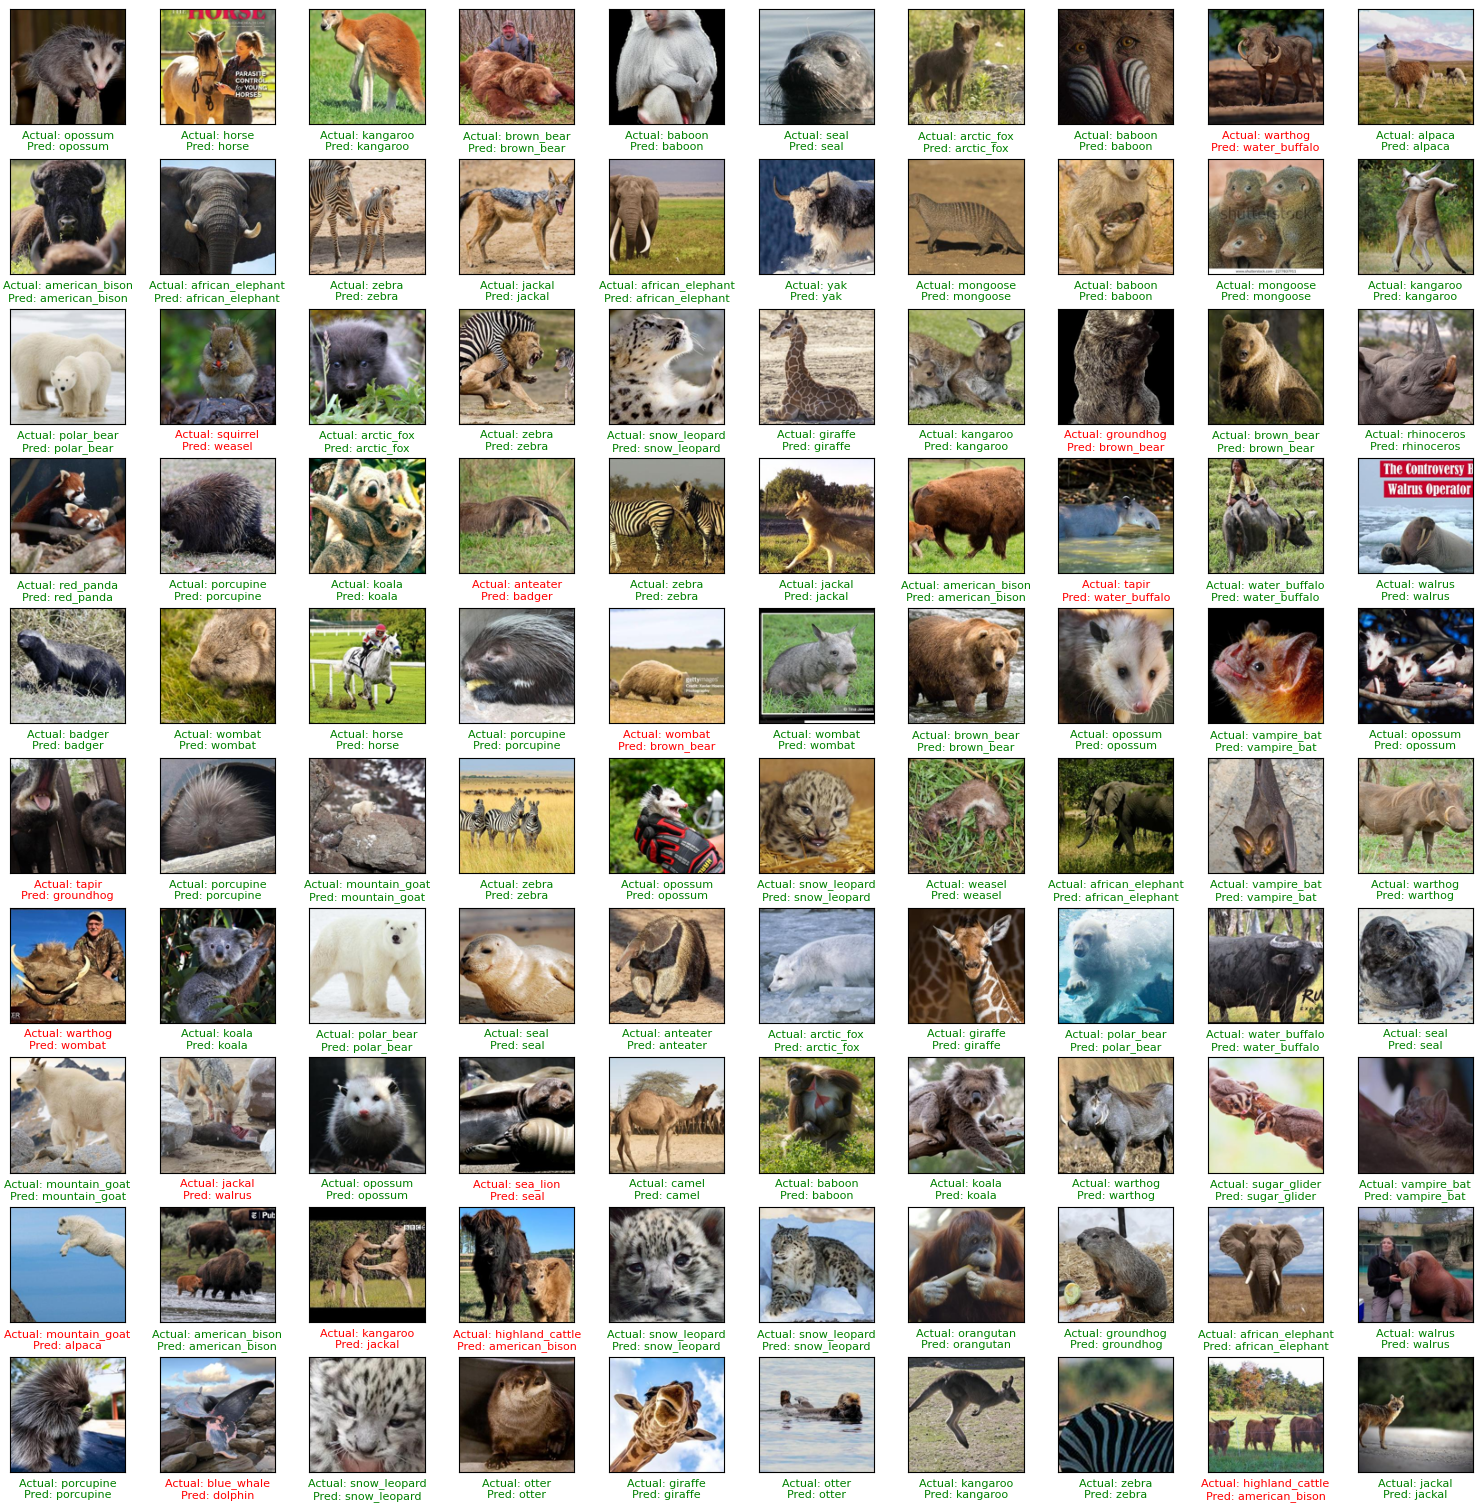

In [ ]:
#@title Plot predictions versus actual class

plt.figure(figsize=(19,19))
for i in tqdm(range(100), desc="Displaying images"):
    plt.subplot(10,10,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])

    col = "green" if test_labels[i]==predicted_class_name[i] else "red"
    plt.xlabel(f"Actual: {test_labels[i]}\nPred: {predicted_class_name[i]}", color=col, fontsize=8)

plt.show()

In [ ]:
#@title Save model

export_path = "saved_model"
model.save(export_path)
!zip -r saved_model.zip saved_model

updating: saved_model/ (stored 0%)
updating: saved_model/variables/ (stored 0%)
updating: saved_model/variables/variables.index (deflated 83%)
updating: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
updating: saved_model/assets/ (stored 0%)
updating: saved_model/keras_metadata.pb (deflated 80%)
updating: saved_model/saved_model.pb (deflated 92%)
updating: saved_model/fingerprint.pb (stored 0%)


# Part 2. Data augmentation

In [ ]:
#@title Unzip model

export_path = "saved_model"
!unzip -o saved_model.zip

Archive:  saved_model.zip
  inflating: saved_model/variables/variables.index  
  inflating: saved_model/variables/variables.data-00000-of-00001  
  inflating: saved_model/keras_metadata.pb  
  inflating: saved_model/saved_model.pb  
 extracting: saved_model/fingerprint.pb  


In [ ]:
#@title Load model in, make it trainable and delete unzipped model (keep zipped)

model = tf_keras.models.load_model(export_path)
model.trainable = True
!rm -r saved_model

In [ ]:
#@title Data augmentation - randomly flip, rotate, change brightness and etc. on image input

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.15),
  tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
  tf.keras.layers.RandomTranslation(0.1, 0.1),
])

In [ ]:
#@title Perform data augmentation on training data

train_images_aug = data_augmentation(train_images_norm)

In [ ]:
#@title Train model with new augmented data

epochs = 2 #@param
history = model.fit(train_images_aug, np.array(train_labels_int), epochs=epochs, validation_data=(validation_images_norm, np.array(validation_labels_int)), batch_size=16)

Epoch 1/2
516/516 [==============================] - 52s 73ms/step - loss: 1.5087 - accuracy: 0.6758 - val_loss: 1.0219 - val_accuracy: 0.8033
Epoch 2/2
516/516 [==============================] - 34s 66ms/step - loss: 0.7154 - accuracy: 0.8029 - val_loss: 0.9859 - val_accuracy: 0.8052


In [ ]:
#@title Measure accuracy of model on test set

test_loss_2, test_acc_2 = model.evaluate(test_images_norm, np.array(test_labels_int), verbose = 0)
print(f"Accuracy: {test_acc_2}\nLoss: {test_loss_2}")
print("\nChanges from pre-augmented training:")
print(f"Accuracy: {test_acc_2 - test_acc_1}\nLoss: {test_loss_2 - test_loss_1}")

Accuracy: 0.8094545602798462
Loss: 0.912963330745697

Changes from pre-augmented training:
Accuracy: 0.004727303981781006
Loss: 0.0434497594833374


In [ ]:
#@title Predict first 100 test images

predicted_class_name = [""] * 100

for i in tqdm(range(100), desc="Predicting images"):
    img = tf.expand_dims(test_images_norm[i], axis=0)
    result = model.predict(img, verbose = 0);

    predicted_class = tf.math.argmax(result[0], axis=-1)
    predicted_class_name[i] = class_names[predicted_class]

Predicting images: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Displaying images: 100%|██████████| 100/100 [00:03<00:00, 32.01it/s]


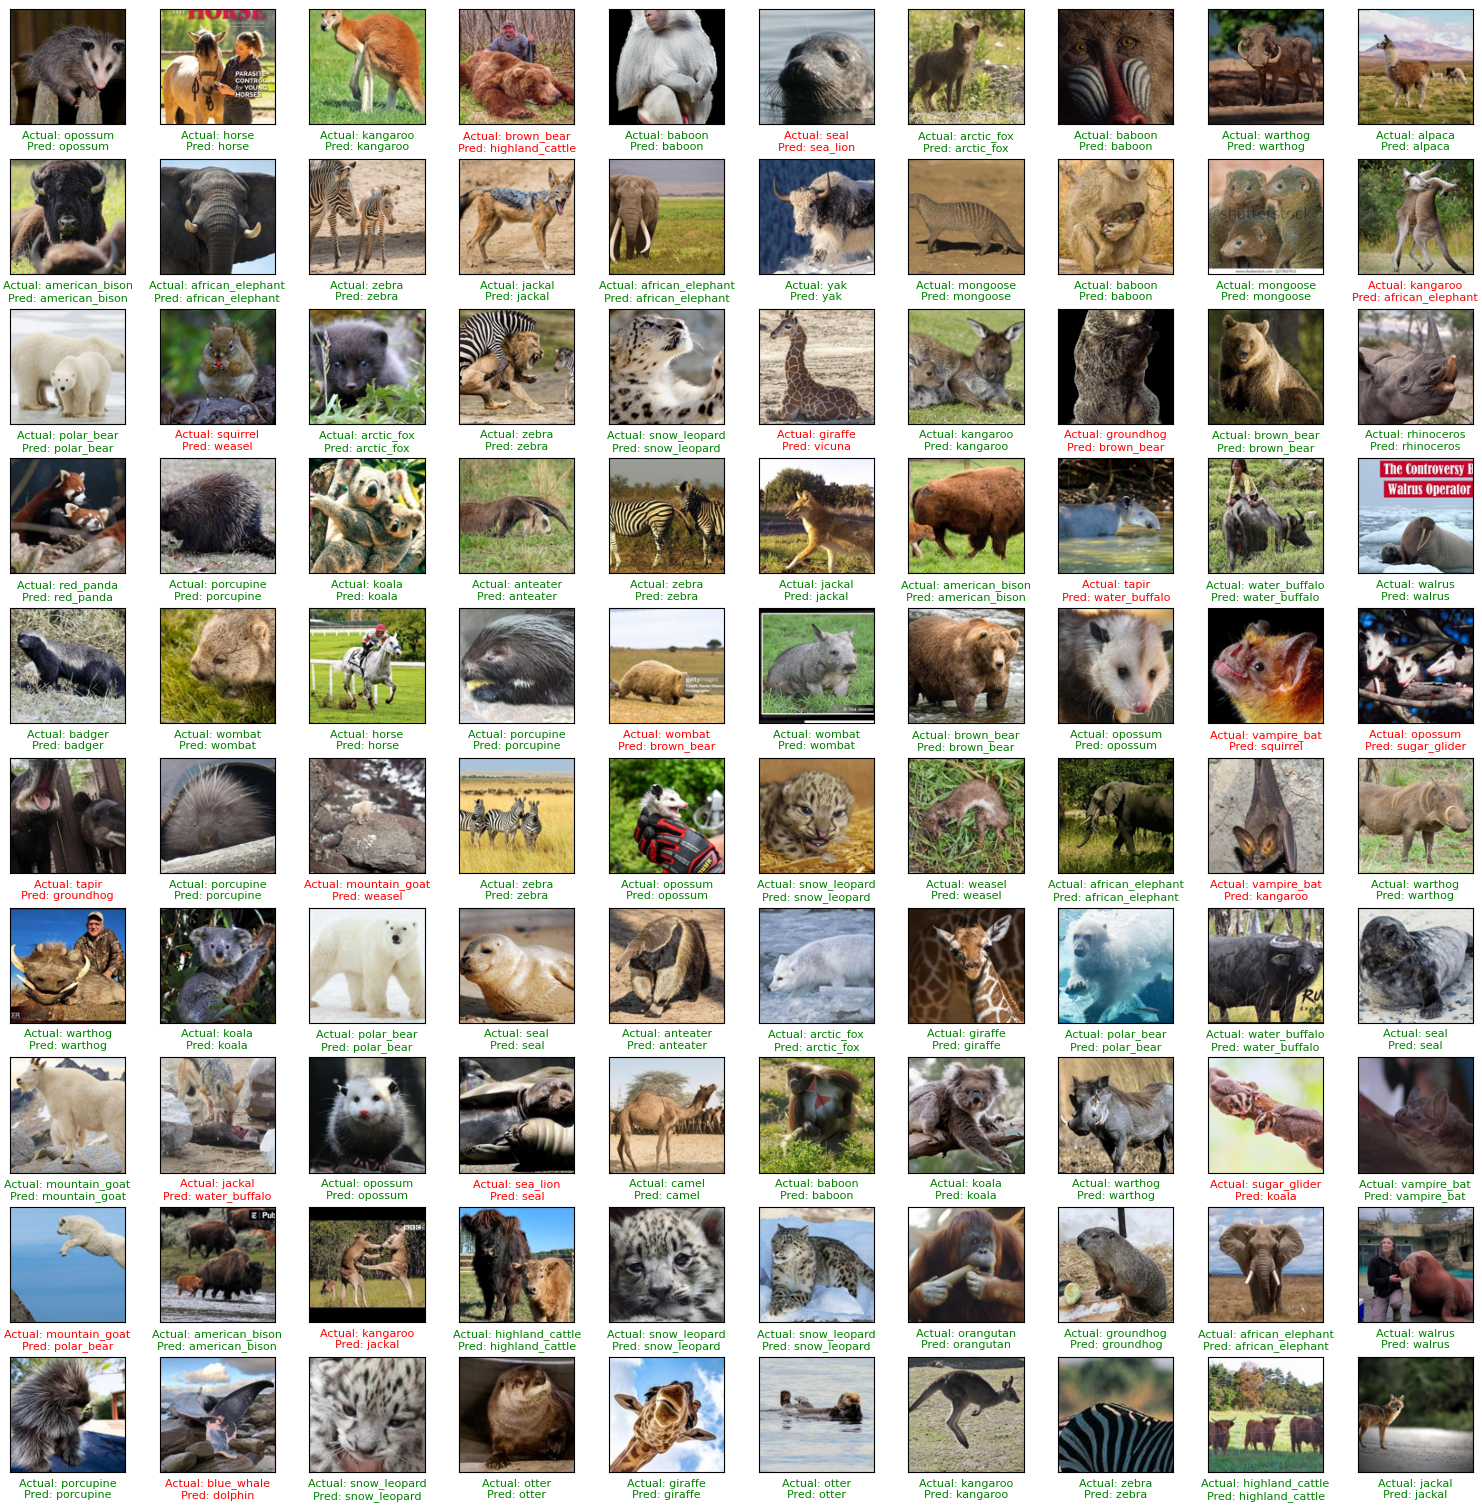

In [ ]:
#@title Plot predictions versus actual class

plt.figure(figsize=(19,19))
for i in tqdm(range(100), desc="Displaying images"):
    plt.subplot(10,10,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])

    col = "green" if test_labels[i]==predicted_class_name[i] else "red"
    plt.xlabel(f"Actual: {test_labels[i]}\nPred: {predicted_class_name[i]}", color=col, fontsize=8)

plt.show()